In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Organizing Data into subsets

In [22]:
# Organize data into TRAIN, VALID, TEST DIRS

os.chdir('/Users/omaraldakheel/dogs-vs-cats/train') # change directory cd into cats-dogs
if os.path.isdir('train/dog') is False: # makes directories of train,valid,test
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')    
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat.*'), 500): # random splitting images into each directory 
        shutil.move(i, 'train/cat' )
    for i in random.sample(glob.glob('dog.*'), 500):
        shutil.move(i, 'train/dog' )    
    for i in random.sample(glob.glob('cat.*'), 100): # splitting for validation and test
        shutil.move(i, 'valid/cat' )
    for i in random.sample(glob.glob('dog.*'), 100):
        shutil.move(i, 'valid/dog' )    
    for i in random.sample(glob.glob('cat.*'), 50): # based on file name therefore it will parse
        shutil.move(i, 'test/cat' )
    for i in random.sample(glob.glob('dog.*'), 50):
        shutil.move(i, 'test/dog' )
os.chdir('../../')

In [23]:
train_path = '/Users/omaraldakheel/dogs-vs-cats/train'
valid_path = '/Users/omaraldakheel/dogs-vs-cats/valid'
test_path  = '/Users/omaraldakheel/dogs-vs-cats/test'

### function that applies preproccesing on images before it goes to neural network 
#### - same format as "vgg16" method process.
#### - target_size resizes images at 224x224 prior to being sent to neural network
#### - shuffle = false because we will use a confusion matrix and access unshuffled labels

In [24]:
# keras generator

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### Visualize The Data

In [25]:
imgs, labels = next(train_batches)

In [26]:
# official tensorFlow Documentation to plot and processed images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..144.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..149.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-103.939..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..132.061].
Clipping input data

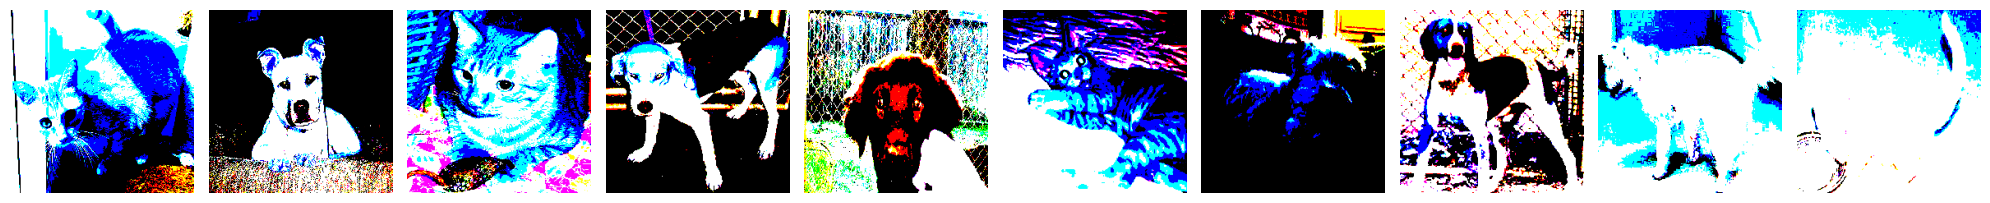

In [27]:
plotImages(imgs)
plt.show()

# Build and Train a Convulutional Neural Network 

In [30]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),

])

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       200,706 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,850 (823.63 KB)

 Trainable params: 210,850 (823.63 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 5s - 51ms/step - accuracy: 0.5600 - loss: 14.1125 - val_accuracy: 0.5350 - val_loss: 6.4762
Epoch 2/10
100/100 - 5s - 48ms/step - accuracy: 0.7220 - loss: 2.8606 - val_accuracy: 0.6250 - val_loss: 3.4438
Epoch 3/10
100/100 - 5s - 49ms/step - accuracy: 0.8250 - loss: 1.2506 - val_accuracy: 0.5800 - val_loss: 3.9296
Epoch 4/10
100/100 - 5s - 48ms/step - accuracy: 0.9090 - loss: 0.4174 - val_accuracy: 0.6000 - val_loss: 2.9282
Epoch 5/10
100/100 - 5s - 48ms/step - accuracy: 0.9750 - loss: 0.0719 - val_accuracy: 0.6150 - val_loss: 3.2435
Epoch 6/10
100/100 - 5s - 49ms/step - accuracy: 0.9950 - loss: 0.0171 - val_accuracy: 0.6300 - val_loss: 2.9964
Epoch 7/10
100/100 - 5s - 49ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.6150 - val_loss: 3.0225
Epoch 8/10
100/100 - 5s - 49ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6150 - val_loss: 3.0119
Epoch 9/10
100/100 - 5s - 50ms/step - accuracy: 1.0000 - loss: 7.6322e-04 - val_accuracy: 0.6150 - val_

# PREDICT

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..131.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-87.68..111.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..151.061].
Clipping input data to 

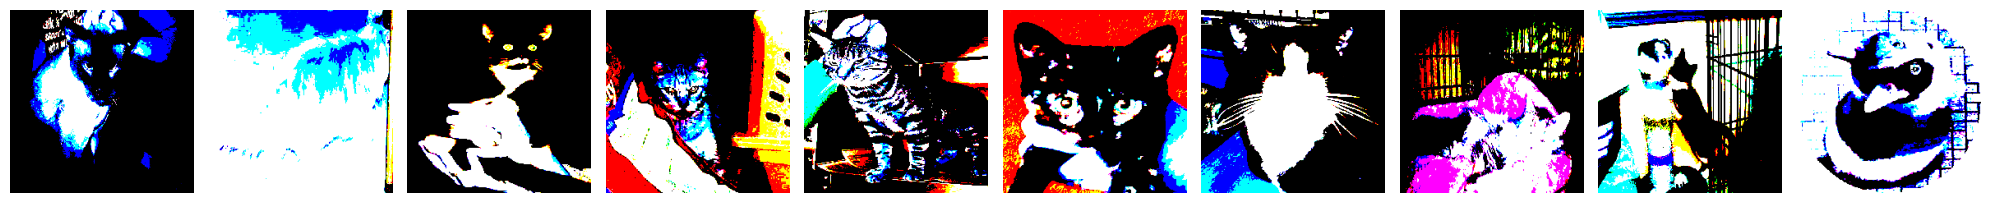

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [35]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [36]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [38]:
predictions = model.predict(x=test_batches, verbose=0)

In [39]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [43]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
test_batches.class_indices


{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[35 15]
 [22 28]]


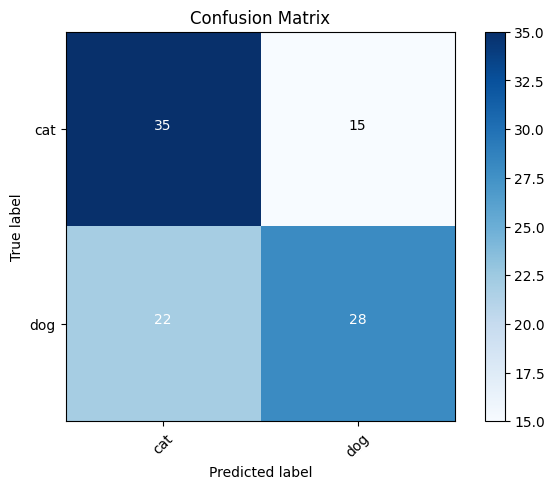

In [46]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Data Augmentation

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [91]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [92]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
                        channel_shift_range=10., horizontal_flip=True)

In [115]:
chosen_image = random.choice(os.listdir('/Users/omaraldakheel/dogs-vs-cats/train/dog/'))

In [116]:
image_path = '/Users/omaraldakheel/dogs-vs-cats/train/dog/' + chosen_image

In [117]:
assert os.path.isfile(image_path)

In [119]:
image = np.expand_dims(plt.imread(image_path), 0)

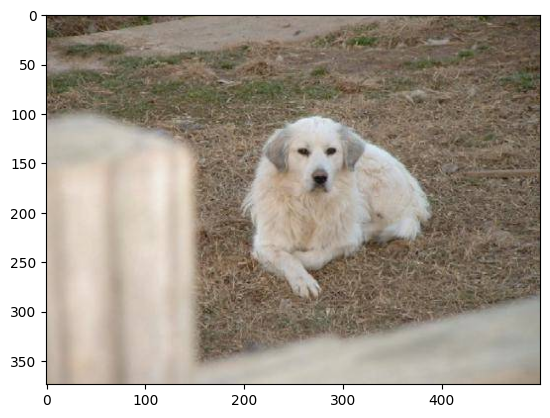

In [120]:
plt.imshow(image[0])

In [121]:
aug_iter = gen.flow(image)

In [123]:
aug_images = [next(aug_iter) [0].astype(np.uint8) for i in range(10)]

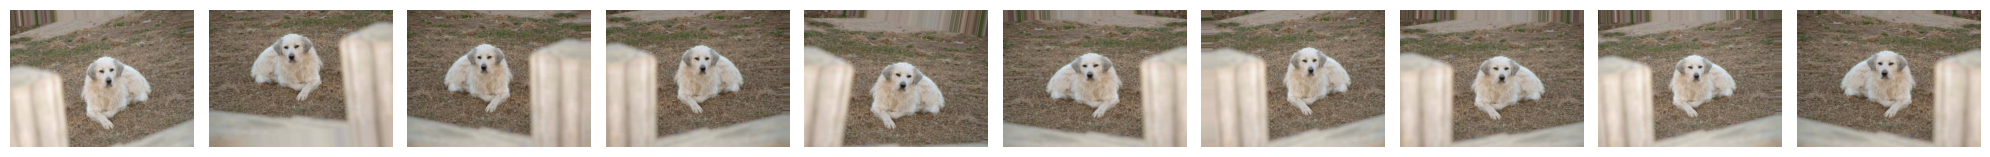

In [124]:
plotImages(aug_images)

In [ ]:
aug_iter = gen.flow(image, save_to_dir='data/dogs-vs-cats/train/dog', save_prefix='aug-image', save_format='jpeg') 